In [1]:
!pip install --upgrade scikit-learn

In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,KFold,cross_val_score

from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error,mean_squared_error,make_scorer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [3]:
train = pd.read_csv("train1.csv",low_memory=False)
train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Data Cleaning

In [4]:
# Irrelavant Features

train.drop(columns=["ID","Name","SSN","Month","Customer_ID","Type_of_Loan"],inplace=True,axis=1)

In [5]:
# TAKE THE FIRST TWO NUMBERS

train["Credit_History_Age"] = train["Credit_History_Age"].str[:2]

In [6]:
# REPLACE "!@9#%8" AND "_______" FROM FEATURES WITH NAN
train = train.replace("!@9#%8",np.nan,regex=True)
train = train.replace("_______",np.nan,regex=True)

In [7]:
# REMOVE THE UNDERSCORES FROM THE END OF TAHE VALUES
train["Age"] = train["Age"].str.rstrip("_")
train["Annual_Income"] = train["Annual_Income"].str.rstrip("_")
train["Outstanding_Debt"] = train["Outstanding_Debt"].str.rstrip("_")
train["Num_of_Loan"] = train["Num_of_Loan"].str.rstrip("_")
train["Num_of_Delayed_Payment"] = train["Num_of_Delayed_Payment"].str.rstrip("_")
train["Amount_invested_monthly"] = train["Amount_invested_monthly"].str.rstrip("_")
train["Monthly_Balance"] = train["Monthly_Balance"].str.rstrip("_")

In [8]:
# REMOVE UNDERSCORES FROM THE COLUMNS

def remove_underscore(train):
    train['Amount_invested_monthly'] = train['Amount_invested_monthly'].str.replace('_', '')
    train['Monthly_Balance'] = train['Monthly_Balance'].str.replace('_','')
    train["Num_of_Delayed_Payment"] = train["Num_of_Delayed_Payment"].str.replace('_','')

    return train

train = remove_underscore(train.copy())

In [9]:
# ENCODING Payment_Behaviour FEATURE TO MAKE IT FIT FOR THE MODEL 

New_one_hot = pd.get_dummies(train["Payment_Behaviour"])
train = pd.concat([train,New_one_hot],axis=1)

In [10]:
Scaler = StandardScaler()
LB = LabelEncoder()

In [11]:
# APPLY LABEL ENCODER AFTER CONCAT THE Payment_Behaviour FEATURE VALUES TO THE DATAFRAME TO MAKE IT FIT FOR THE MODEL

train['High_spent_Large_value_payments'] = LB.fit_transform(train['High_spent_Large_value_payments'])
train['High_spent_Medium_value_payments'] = LB.fit_transform(train['High_spent_Medium_value_payments'])
train['High_spent_Small_value_payments'] = LB.fit_transform(train['High_spent_Small_value_payments'])

train['Low_spent_Large_value_payments'] = LB.fit_transform(train['Low_spent_Large_value_payments'])
train['Low_spent_Medium_value_payments'] = LB.fit_transform(train['Low_spent_Medium_value_payments'])
train['Low_spent_Small_value_payments'] = LB.fit_transform(train['Low_spent_Small_value_payments'])

train.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,High_spent_Large_value_payments,High_spent_Medium_value_payments,High_spent_Small_value_payments,Low_spent_Large_value_payments,Low_spent_Medium_value_payments,Low_spent_Small_value_payments
0,23,Scientist,19114.12,1824.843333,3,4,3,4,3,7,...,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,0,0,1,0,0,0
1,23,Scientist,19114.12,NaN,3,4,3,4,-1,NaN,...,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,0,0,0,1,0,0
2,-500,Scientist,19114.12,NaN,3,4,3,4,3,7,...,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,0,0,0,0,1,0
3,23,Scientist,19114.12,NaN,3,4,3,4,5,4,...,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,0,0,0,0,0,1
4,23,Scientist,19114.12,1824.843333,3,4,3,4,6,NaN,...,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,0,1,0,0,0,0


In [12]:
# DROPPED THE MAIN FEATURE AFTER ENCODING AND LABELD IT 

train.drop("Payment_Behaviour",axis=1,inplace=True)

In [13]:
# ENCODING Occupation FEATURE TO MAKE IT FIT FOR THE MODEL

one_hot_Occupation = pd.get_dummies(train["Occupation"])
train = pd.concat([train,one_hot_Occupation],axis=1)
train

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer
0,23,Scientist,19114.12,1824.843333,3,4,3,4,3,7,...,False,False,False,False,False,False,False,True,False,False
1,23,Scientist,19114.12,NaN,3,4,3,4,-1,NaN,...,False,False,False,False,False,False,False,True,False,False
2,-500,Scientist,19114.12,NaN,3,4,3,4,3,7,...,False,False,False,False,False,False,False,True,False,False
3,23,Scientist,19114.12,NaN,3,4,3,4,5,4,...,False,False,False,False,False,False,False,True,False,False
4,23,Scientist,19114.12,1824.843333,3,4,3,4,6,NaN,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,Mechanic,39628.99,3359.415833,4,6,7,2,23,7,...,False,False,False,False,True,False,False,False,False,False
99996,25,Mechanic,39628.99,3359.415833,4,6,7,2,18,7,...,False,False,False,False,True,False,False,False,False,False
99997,25,Mechanic,39628.99,3359.415833,4,6,5729,2,27,6,...,False,False,False,False,True,False,False,False,False,False
99998,25,Mechanic,39628.99,3359.415833,4,6,7,2,20,NaN,...,False,False,False,False,True,False,False,False,False,False


In [14]:
# APPLY LABEL ENCODER AFTER CONCAT THE Occupation FEATURE VALUES TO THE DATAFRAME TO MAKE IT FIT FOR THE MODEL

train['Scientist'] = LB.fit_transform(train['Scientist'])
train['Teacher'] = LB.fit_transform(train['Teacher'])
train['Developer'] = LB.fit_transform(train['Developer'])

train['Lawyer'] = LB.fit_transform(train['Lawyer'])
train['Entrepreneur'] = LB.fit_transform(train['Entrepreneur'])
train['Accountant'] = LB.fit_transform(train['Accountant'])

train['Mechanic'] = LB.fit_transform(train['Mechanic'])
train['Writer'] = LB.fit_transform(train['Writer'])
train['Manager'] = LB.fit_transform(train['Manager'])

train['Media_Manager'] = LB.fit_transform(train['Media_Manager'])
train['Musician'] = LB.fit_transform(train['Musician'])
train['Journalist'] = LB.fit_transform(train['Journalist'])

train['Architect'] = LB.fit_transform(train['Architect'])
train['Doctor'] = LB.fit_transform(train['Doctor'])
train['Engineer'] = LB.fit_transform(train['Engineer'])

# DROPPED THE MAIN FEATURE AFTER ENCODING AND LABELD IT 
train.drop("Occupation",inplace=True,axis=1)

train.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer
0,23,19114.12,1824.843333,3,4,3,4,3,7,11.27,...,0,0,0,0,0,0,0,1,0,0
1,23,19114.12,NaN,3,4,3,4,-1,NaN,11.27,...,0,0,0,0,0,0,0,1,0,0
2,-500,19114.12,NaN,3,4,3,4,3,7,_,...,0,0,0,0,0,0,0,1,0,0
3,23,19114.12,NaN,3,4,3,4,5,4,6.27,...,0,0,0,0,0,0,0,1,0,0
4,23,19114.12,1824.843333,3,4,3,4,6,NaN,11.27,...,0,0,0,0,0,0,0,1,0,0


In [15]:
# LABEL THE FEATURES TO MAKE IT FIT FOR THE MODEL 

train["Credit_Mix"] = LB.fit_transform(train["Credit_Mix"])
train["Credit_Score"] = LB.fit_transform(train["Credit_Score"])
train["Payment_of_Min_Amount"] = LB.fit_transform(train["Payment_of_Min_Amount"])

In [16]:
# REPLACE THE UNDERSCORES FROM Changed_Credit_Limit FEATURE WITH NAN

train["Changed_Credit_Limit"] = train["Changed_Credit_Limit"].replace("_",np.nan)

In [17]:
# FILL NA WITH MEDIAN

train = train.fillna(train.median())

In [18]:
# CHANGE THE TYPES OF THE DATASET

train = train.astype({
                     "Num_of_Loan":int,
                     "Num_of_Delayed_Payment":float,
                     "Outstanding_Debt":float,
                     "Payment_of_Min_Amount":int,
                     "Amount_invested_monthly":float,
                     "Monthly_Balance":float,
                     "Credit_History_Age": int,
                     "Changed_Credit_Limit": float,
                     "Credit_History_Age": int,
                     "Age": int,
                     "Annual_Income":float})

In [19]:
# NO NAN VALUES

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               100000 non-null  int32  
 1   Annual_Income                     100000 non-null  float64
 2   Monthly_Inhand_Salary             100000 non-null  float64
 3   Num_Bank_Accounts                 100000 non-null  int64  
 4   Num_Credit_Card                   100000 non-null  int64  
 5   Interest_Rate                     100000 non-null  int64  
 6   Num_of_Loan                       100000 non-null  int32  
 7   Delay_from_due_date               100000 non-null  int64  
 8   Num_of_Delayed_Payment            100000 non-null  float64
 9   Changed_Credit_Limit              100000 non-null  float64
 10  Num_Credit_Inquiries              100000 non-null  float64
 11  Credit_Mix                        100000 non-null  in

## Data Preprocessing

In [20]:
train.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,110.649700,1.764157e+05,4029.084964,17.091280,22.47443,72.466040,3.009960,21.068780,29.738370,10.368345,...,0.061740,0.060850,0.065750,0.059730,0.062910,0.062320,0.059110,0.062990,0.062150,0.058850
std,686.244717,1.429618e+06,2961.363540,117.404834,129.05741,466.422621,62.647879,14.860104,218.017612,6.719627,...,0.240684,0.239056,0.247846,0.236987,0.242802,0.241737,0.235832,0.242946,0.241429,0.235345
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.945750e+04,1792.084167,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.420000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,7.279092e+04,5371.525000,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.660000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# AGE WRONG VALUES AND OUTLIERS

Age_Outliers = train[(train["Age"] < 16) | (train['Age'] > 90)].index
train.drop(Age_Outliers,inplace=True)

<Axes: ylabel='Age'>

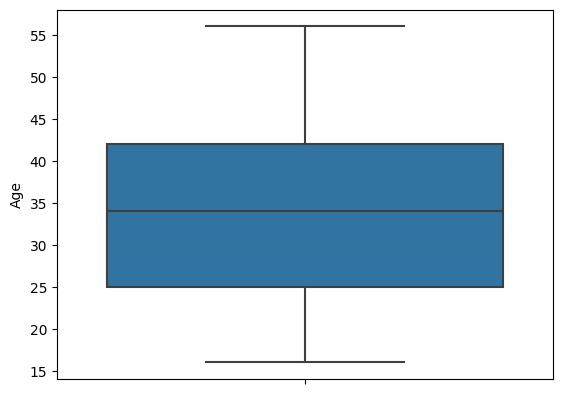

In [22]:
sns.boxplot(y = train['Age'],data=train)

In [23]:
# CHECKING THE 0.95 QUANTILE TO DETECT OUTLIERS LIMIT

train['Annual_Income'].quantile(0.95)

134951.25

In [24]:
# DROP OUTLIERS 0F ANNUAL INCOME FEATURE BY INDEX

Annual_Income_Outliers = train[train['Annual_Income'] > 134952].index
train.drop(Annual_Income_Outliers,inplace=True)

<Axes: ylabel='Annual_Income'>

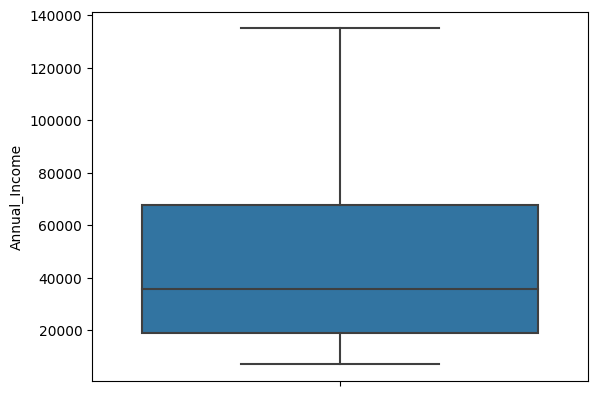

In [25]:
sns.boxplot(y = train['Annual_Income'],data=train)

In [26]:
train['Monthly_Inhand_Salary'].quantile(0.95)

9272.94

In [27]:
# NO OUTLIERS 0F Monthly_Inhand_Salary FEATURE
#BECAUSE THERE'S A LOT OF RECOREDS THAT BIGGER THAN THE 0.95 QUANTILE NOT IRREGULARITY

Monthly_Inhand_Salary_Outliers = train[train['Monthly_Inhand_Salary'] > 9300].index
Monthly_Inhand_Salary_Outliers.value_counts()

48       1
68487    1
68558    1
68557    1
68556    1
        ..
35719    1
35992    1
35993    1
35994    1
99879    1
Name: count, Length: 4410, dtype: int64

<Axes: ylabel='Monthly_Inhand_Salary'>

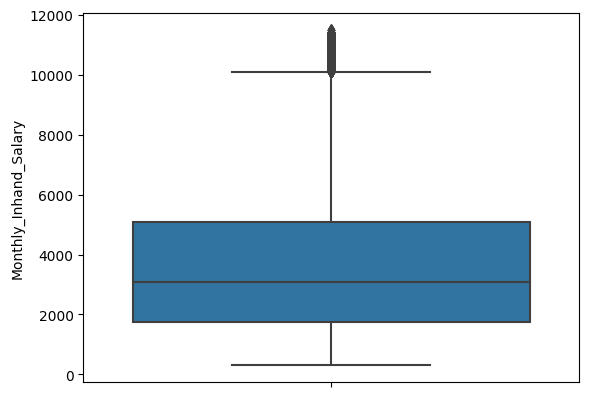

In [28]:
sns.boxplot(y = train['Monthly_Inhand_Salary'],data=train)

In [29]:
train["Num_Bank_Accounts"].quantile(0.95)

10.0

In [30]:
# I CHOOSED TO DROP VALUES LARGER THAN 17 BECAUSE THERE WAS A LOT OF RECOREDS LARGER THAN 17

Num_Bank_Accounts_Outliers = train[(train["Num_Bank_Accounts"] > 17) | (train['Num_Bank_Accounts'] < 0)].index
train.drop(Num_Bank_Accounts_Outliers,inplace=True)

<Axes: ylabel='Num_Bank_Accounts'>

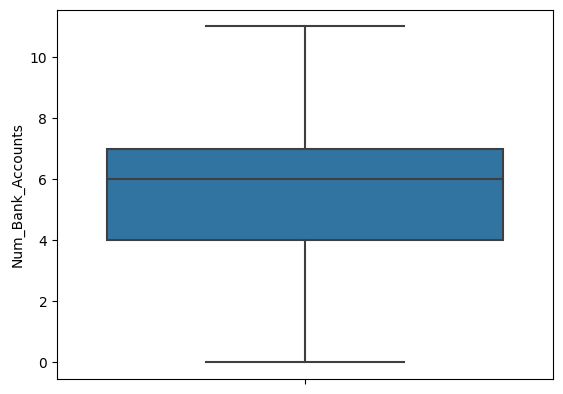

In [31]:
sns.boxplot(y = train['Num_Bank_Accounts'],data=train)

In [32]:
train["Num_Credit_Card"].quantile(0.95)

10.0

In [33]:
# DROPPED THE VALUES WHICH IS LARGER THAN 14 BECAUSE THE (0.95) QUANTILE IS 10 AND CONTAINS A BIG AMOUNT OF VALUES

Num_Credit_Card_Outliers = train[(train["Num_Credit_Card"] > 14) | (train['Num_Credit_Card'] < 0)].index
train.drop(Num_Credit_Card_Outliers,inplace=True)

<Axes: ylabel='Num_Credit_Card'>

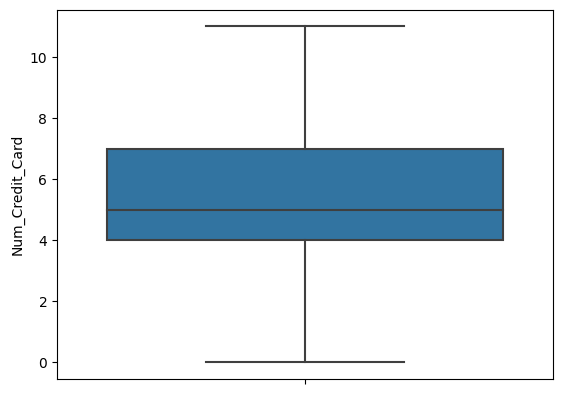

In [34]:
sns.boxplot(y = train['Num_Credit_Card'],data=train)

In [35]:
train["Interest_Rate"].quantile(0.95)

33.0

In [36]:
# VALUES LARGER THAN 33 WAS MORE THAN 3000 I CHOOSED TO DROP THE VALUES LARGER THAN 50 TO AVOID DELETE A LOT FROM THE DATASET 

Interest_Rate_Outliers = train[(train["Interest_Rate"] > 50) | (train['Interest_Rate'] < 0)].index
train.drop(Interest_Rate_Outliers,inplace=True)

<Axes: ylabel='Interest_Rate'>

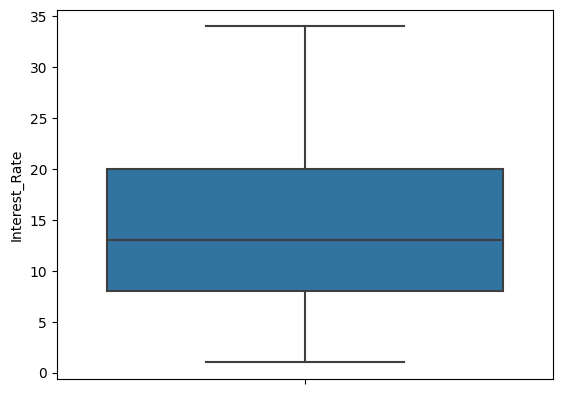

In [37]:
sns.boxplot(y = train['Interest_Rate'],data=train)

In [38]:
train["Num_of_Loan"].quantile(0.95)

8.0

In [39]:
# IT'S ABNORMAL IF SOMEONE TOOK MORE THAN 10 LOAN! 

Num_of_Loan_Outliers = train[(train["Num_of_Loan"] > 10) | (train['Num_of_Loan'] < 0)].index
train.drop(Num_of_Loan_Outliers,inplace=True)

<Axes: ylabel='Num_of_Loan'>

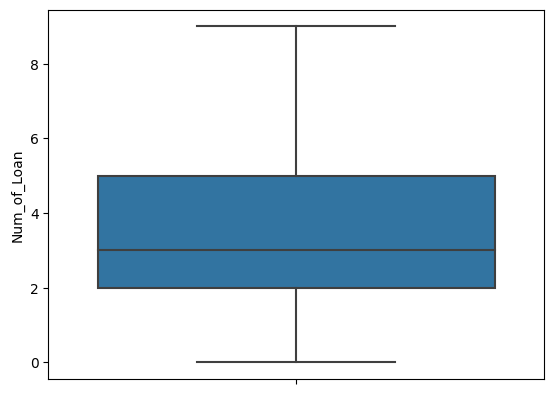

In [40]:
sns.boxplot(y = train['Num_of_Loan'],data=train)

In [41]:
train["Delay_from_due_date"].quantile(0.95)

54.0

In [42]:
# LARGE GAP BETWEEN 54 AND 60 I CHOOSED TO DROP VALUES LARGER THAN 60 TO AVOID DELETE FROM THE DATA
# SO THERE'S A POSSIBILITY THAT THE VALUES LARGER THAN 54 NOT A OUTLIER

Delay_from_due_date_Outliers = train[(train["Delay_from_due_date"] > 60) | (train['Delay_from_due_date'] < 0)].index
train.drop(Delay_from_due_date_Outliers,inplace=True)

<Axes: ylabel='Delay_from_due_date'>

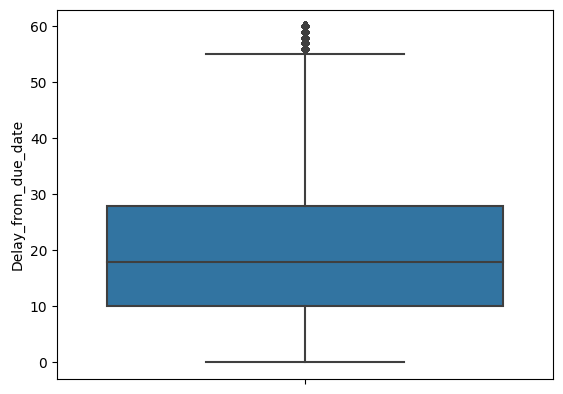

In [43]:
sns.boxplot(y = train['Delay_from_due_date'],data=train)

In [44]:
train["Num_of_Delayed_Payment"].quantile(0.95)

23.0

In [45]:
# LARGE GAP BETWEEN VALUES BIGGER THAN 23 AND VALUES BIGGER THAN 30

Num_of_Delayed_Payment_Outliers = train[(train["Num_of_Delayed_Payment"] > 30) | (train['Num_of_Delayed_Payment'] < 0)].index
train.drop(Num_of_Delayed_Payment_Outliers,inplace=True)

<Axes: ylabel='Num_of_Delayed_Payment'>

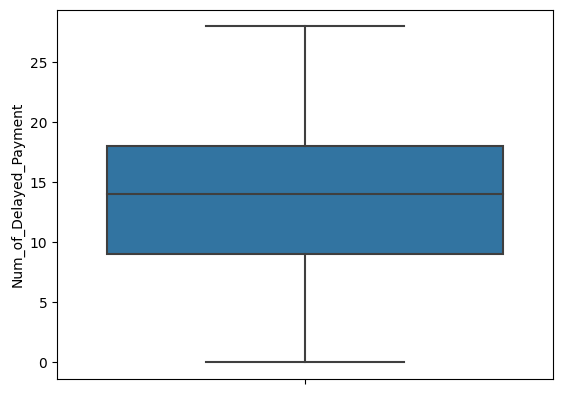

In [46]:
sns.boxplot(y = train['Num_of_Delayed_Payment'],data=train)

In [47]:
train["Changed_Credit_Limit"].quantile(0.95)

23.6

In [48]:
# I CHOOSED 26 FOR THE BIG GAP BETWEEN 30 AND 0.95 QUANTILE

Changed_Credit_Limit_Outliers = train[(train["Changed_Credit_Limit"] > 26) | (train['Changed_Credit_Limit'] < 0)].index
train.drop(Changed_Credit_Limit_Outliers,inplace=True)

<Axes: ylabel='Changed_Credit_Limit'>

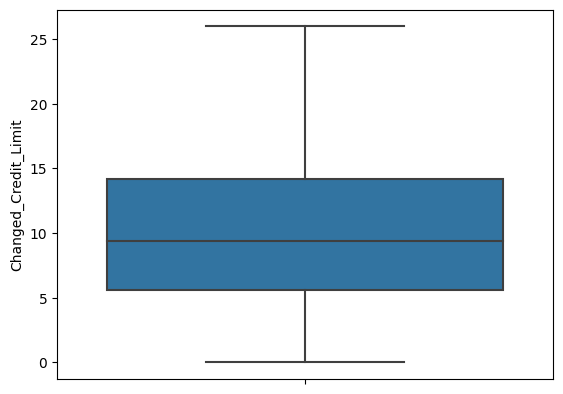

In [49]:
sns.boxplot(y = train['Changed_Credit_Limit'],data=train)

In [50]:
train["Outstanding_Debt"].quantile(0.95)

3844.13

In [51]:
# MY VISION VALUES LARGER THAN 3844 ARE NOT OUTLIERS BECAUSE OF IT'S MUCH MORE THAN 3000 VALUE

Outstanding_Debt_Outliers = train[(train["Outstanding_Debt"] > 4000) | (train['Outstanding_Debt'] < 0)].index
train.drop(Outstanding_Debt_Outliers,inplace=True)

<Axes: ylabel='Outstanding_Debt'>

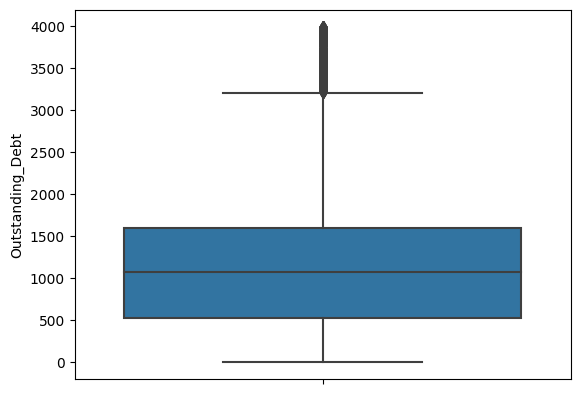

In [52]:
sns.boxplot(y = train['Outstanding_Debt'],data=train)

In [53]:
train["Amount_invested_monthly"].quantile(0.95)

923.5760740444855

In [54]:
# THERE ARE MORE THAN 3200 VALUE BIGER THAN 924 THAT'S WHY I CHOOSED 950

Amount_invested_monthly_Outliers = train[(train["Amount_invested_monthly"] > 950) | (train['Amount_invested_monthly'] < 0)].index
train.drop(Amount_invested_monthly_Outliers,inplace=True)

<Axes: ylabel='Amount_invested_monthly'>

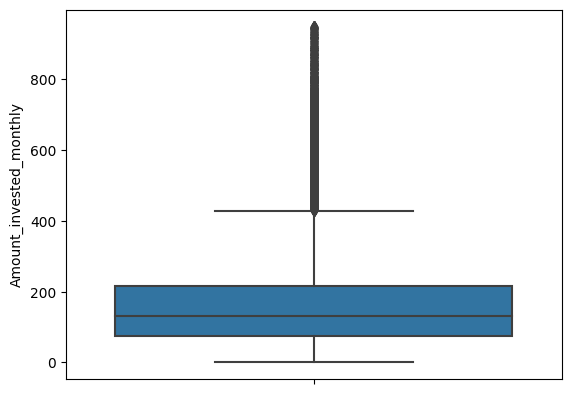

In [55]:
# I CONSIDER THESE VALUES ARE NOT OUTLIERS

sns.boxplot(y = train['Amount_invested_monthly'],data=train)

In [56]:
train["Monthly_Balance"].quantile(0.95)

802.9972783681391

In [57]:
# I SEE VALUES WHICH APPEARS IN THE BOXPLOT ARE NOT OUTLIERS 

Monthly_Balance_Outliers = train[(train["Monthly_Balance"] > 810) | (train['Monthly_Balance'] < 0)].index
train.drop(Monthly_Balance_Outliers,inplace=True)

<Axes: ylabel='Monthly_Balance'>

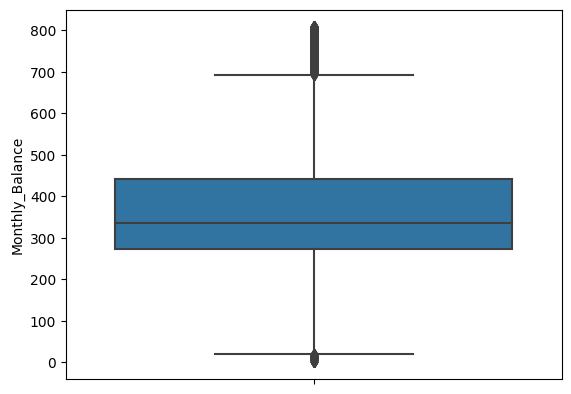

In [58]:
sns.boxplot(y = train['Monthly_Balance'],data=train)

In [59]:
train["Total_EMI_per_month"].quantile(0.95)

399.50424185666805

In [60]:
# THERE'S A LOT OF VALUES BIGGER THAN 400 SO I CONSIDERD IT NOT A OUTLIER

Total_EMI_per_month_Outliers = train[(train["Total_EMI_per_month"] > 450) | (train['Total_EMI_per_month'] < 0)].index
train.drop(Total_EMI_per_month_Outliers,inplace=True)

<Axes: ylabel='Total_EMI_per_month'>

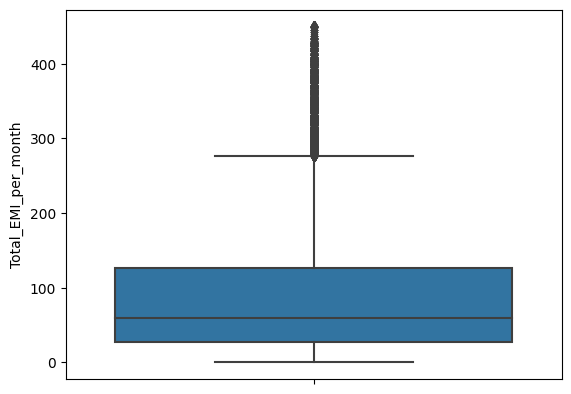

In [61]:
sns.boxplot(y = train['Total_EMI_per_month'],data=train)

In [62]:
train["Credit_Utilization_Ratio"].quantile(0.95)

39.85607438756283

In [63]:
# I DIDN'T EXPAND FAR FROM THE 0.95 QUANTILE BECAUSE VALUES BIGGER THAN IT WAS A LITTLE

Credit_Utilization_Ratio_Outliers = train[(train["Credit_Utilization_Ratio"] > 42) | (train['Credit_Utilization_Ratio'] < 0)].index
train.drop(Credit_Utilization_Ratio_Outliers,inplace=True)

<Axes: ylabel='Credit_Utilization_Ratio'>

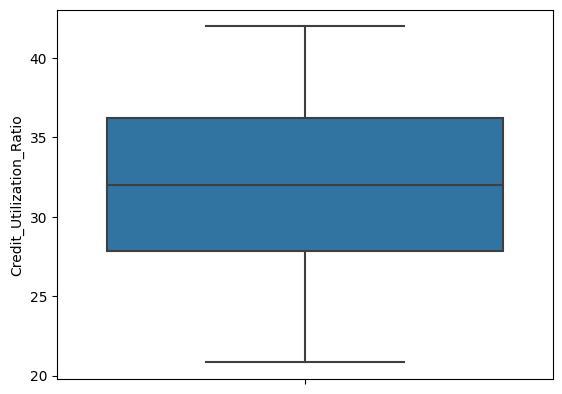

In [64]:
sns.boxplot(y = train['Credit_Utilization_Ratio'],data=train)

In [65]:
# SPLITING THE DATA TO X AN y

X = train.drop("Credit_Score",axis=1).values
y = train["Credit_Score"].values

In [66]:
# USING SMOTE TO DEAL WITH THE IMBALANCED DATA IN y

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61647 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               61647 non-null  int32  
 1   Annual_Income                     61647 non-null  float64
 2   Monthly_Inhand_Salary             61647 non-null  float64
 3   Num_Bank_Accounts                 61647 non-null  int64  
 4   Num_Credit_Card                   61647 non-null  int64  
 5   Interest_Rate                     61647 non-null  int64  
 6   Num_of_Loan                       61647 non-null  int32  
 7   Delay_from_due_date               61647 non-null  int64  
 8   Num_of_Delayed_Payment            61647 non-null  float64
 9   Changed_Credit_Limit              61647 non-null  float64
 10  Num_Credit_Inquiries              61647 non-null  float64
 11  Credit_Mix                        61647 non-null  int32  
 12  Outstandi

In [68]:
train.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer
count,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.00000,61647.000000,...,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000,61647.000000
mean,33.897221,43061.666155,3513.133859,5.321621,5.432835,14.156991,3.383149,20.020358,13.28050,9.904655,...,0.062550,0.062955,0.066767,0.058251,0.062485,0.061852,0.057797,0.063442,0.061593,0.059954
std,10.446540,29330.950773,2265.455760,2.507563,1.993874,8.429921,2.285065,13.491934,5.74642,5.663015,...,0.242153,0.242884,0.249620,0.234219,0.242036,0.240889,0.233361,0.243758,0.240416,0.237404
min,16.000000,7006.035000,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,18983.070000,1727.350000,3.000000,4.000000,7.000000,2.000000,10.000000,9.00000,5.590000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,34378.870000,3093.745000,5.000000,5.000000,13.000000,3.000000,17.000000,14.00000,9.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,61884.420000,4734.566667,7.000000,7.000000,19.000000,5.000000,27.000000,17.00000,13.735000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,56.000000,134951.250000,11429.170000,11.000000,11.000000,34.000000,9.000000,60.000000,28.00000,26.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling Using XGboost

In [69]:
# SPLIT THE DATA TO TRAINNING AND VALIDATION

X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [70]:
# USING GridSearch

# LITTLE OVERFITTING BUT LOWER ACCURACY,PRECISON,F1 SCORE
# 91 TRAIN ----- 86 TEST
# gamma=2,max_depth=7,reg_lambda=0.001

In [71]:
XGBC_ValidationClassifier = XGBClassifier(gamma= 0.1,max_depth = 10,reg_lambda= 0.001)

In [72]:
XGBC_ValidationClassifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [73]:
y_pred = XGBC_ValidationClassifier.predict(X_valid)
y_pred

array([0, 1, 1, ..., 2, 0, 0], dtype=int64)

In [74]:
XGBC_ValidationClassifier.score(X_train,y_train)

0.995389475481686

In [75]:
# OVERFITTING

XGBC_ValidationClassifier.score(X_valid,y_valid)

0.8678199083604489

### XGboost Evaluation

In [76]:
cm = confusion_matrix(y_pred,y_valid)
cm

array([[9308,  329,  717],
       [  66, 8736, 1186],
       [ 729,  954, 8093]], dtype=int64)

In [77]:
print(classification_report(y_pred,y_valid))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     10354
           1       0.87      0.87      0.87      9988
           2       0.81      0.83      0.82      9776

    accuracy                           0.87     30118
   macro avg       0.87      0.87      0.87     30118
weighted avg       0.87      0.87      0.87     30118



In [316]:
MAE = mean_absolute_error(y_valid,y_pred)
MAE

0.18019124775881531

In [318]:
RMSE = np.sqrt(mean_squared_error(y_pred,y_valid))
RMSE

0.525560234414043

In [312]:
mae_scorer = make_scorer(mean_absolute_error)

In [314]:
cv_errors = cross_val_score(XGBClassifier(),X,y,scoring=mae_scorer,cv=10)
cv_errors

array([0.41816707, 0.41557178, 0.40989457, 0.38540146, 0.40957015,
       0.41427413, 0.39983779, 0.41920831, 0.40850097, 0.39974043])

## Modeling Using RandomForest Classifier

In [299]:
# 93 TRAIN ----- 83 TEST
# max_depth=22,min_samples_split=7

In [300]:
RFC = RandomForestClassifier()

In [301]:
RFC.fit(X_train,y_train)

RandomForestClassifier()

In [302]:
y_pred2 = RFC.predict(X_valid)

In [303]:
RFC.score(X_train,y_train)

1.0

In [304]:
# OVERFITTING

RFC.score(X_valid,y_valid)

0.8487283352148217

### RandomForest Evaluation

In [305]:
cm2 = confusion_matrix(y_pred2,y_valid)
cm2

array([[9393,  718, 1081],
       [  74, 8541, 1287],
       [ 636,  760, 7628]], dtype=int64)

In [306]:
# XGBOOST CLASSIFIER HAVE HIGHER F1 SCORE AND LOWER OVERFITTING

print(classification_report(y_pred2,y_valid))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     11192
           1       0.85      0.86      0.86      9902
           2       0.76      0.85      0.80      9024

    accuracy                           0.85     30118
   macro avg       0.85      0.85      0.85     30118
weighted avg       0.85      0.85      0.85     30118



## Modeling Using K-NN

In [290]:
KNN_Classifier = KNeighborsClassifier(n_neighbors=2, algorithm = "ball_tree")

In [291]:
KNN_Classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2)

In [292]:
y_predNeighbors = KNN_Classifier.predict(X_valid)

In [293]:
KNN_Classifier.score(X_train,y_train)

0.8985400005692006

In [294]:
KNN_Classifier.score(X_valid,y_valid)

0.8128029749651371

In [295]:
cm3 = confusion_matrix(y_predNeighbors,y_valid)
cm3

array([[9772,  306, 2382],
       [ 100, 9365, 2271],
       [ 231,  348, 5343]], dtype=int64)

In [296]:
print(classification_report(y_predNeighbors,y_valid))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     12460
           1       0.93      0.80      0.86     11736
           2       0.53      0.90      0.67      5922

    accuracy                           0.81     30118
   macro avg       0.81      0.83      0.80     30118
weighted avg       0.87      0.81      0.83     30118



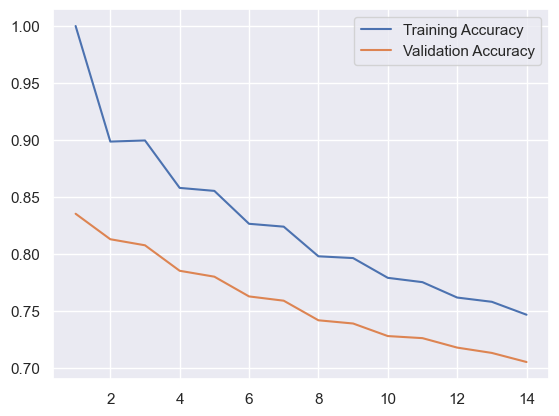

In [297]:
# TUNINNIG FOR NUM OF NEIGHBORS

Train_accuracy=[]
Validation_accuracy=[]

for i in range(1,15):
    KNN_Classifier=KNeighborsClassifier(n_neighbors=i)
    KNN_Classifier.fit(X_train,y_train)
    Train_accuracy.append(KNN_Classifier.score(X_train,y_train))
    Validation_accuracy.append(KNN_Classifier.score(X_valid,y_valid))
num_neighbors=np.array([i for i in range(1,15)])
plt.plot(num_neighbors,Train_accuracy,label = 'Training Accuracy')
plt.plot(num_neighbors,Validation_accuracy,label = 'Validation Accuracy')
plt.legend()
plt.show()

In [298]:
Accuracies = pd.DataFrame({"Train_accuracy":Train_accuracy,"Validation_accuracy":Validation_accuracy,"No_Neighbors":num_neighbors})
Accuracies

,Train_accuracy,Validation_accuracy,No_Neighbors
0,1.000000,0.835182,1
1,0.898540,0.812803,2
2,0.899522,0.807491,3
3,0.857871,0.785112,4
4,0.855252,0.779932,5
5,0.826365,0.762600,6
6,0.823847,0.758849,7
7,0.797820,0.741650,8
8,0.796269,0.738827,9
9,0.778923,0.727804,10
